In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_B_over_ganaug_025"
plot_title = "train_B_over_ganaug_025"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.853981,0.852448,0.709525,0.852448,0.950449,0.899927,0.914063,0.776030
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.884685,0.885954,0.767089,0.885954,0.966387,0.926231,0.940491,0.828558
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.895230,0.896263,0.793540,0.896263,0.970422,0.935235,0.947722,0.848733
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.895784,0.895619,0.795898,0.895619,0.971465,0.940198,0.949221,0.858068
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.902632,0.903995,0.806380,0.903995,0.974242,0.944324,0.954293,0.865004


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.850295,0.848582,0.706536,0.848582,0.948763,0.895708,0.913524,0.769348
1,2,test,0.877881,0.878222,0.758679,0.878222,0.964284,0.921955,0.938697,0.825377
2,3,test,0.891457,0.891753,0.787636,0.891753,0.968142,0.929540,0.945693,0.844412
3,4,test,0.889923,0.889175,0.790625,0.889175,0.968741,0.933118,0.946831,0.854299
4,5,test,0.895469,0.896263,0.794709,0.896263,0.971561,0.935651,0.951824,0.860123


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/262:,Train,Loss,=,1.252,Valid,Loss,=,1.215,ETA,=,4.40h
1,Epoch,"1/40,",Batch,20/262:,Train,Loss,=,1.215,Valid,Loss,=,1.187,ETA,=,4.26h
2,Epoch,"1/40,",Batch,30/262:,Train,Loss,=,1.155,Valid,Loss,=,1.114,ETA,=,3.76h
3,Epoch,"1/40,",Batch,40/262:,Train,Loss,=,1.131,Valid,Loss,=,1.064,ETA,=,3.53h
4,Epoch,"1/40,",Batch,50/262:,Train,Loss,=,1.083,Valid,Loss,=,1.031,ETA,=,3.34h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.252,1.215
20,1,20,1.215,1.187
30,1,30,1.155,1.114
40,1,40,1.131,1.064
50,1,50,1.083,1.031


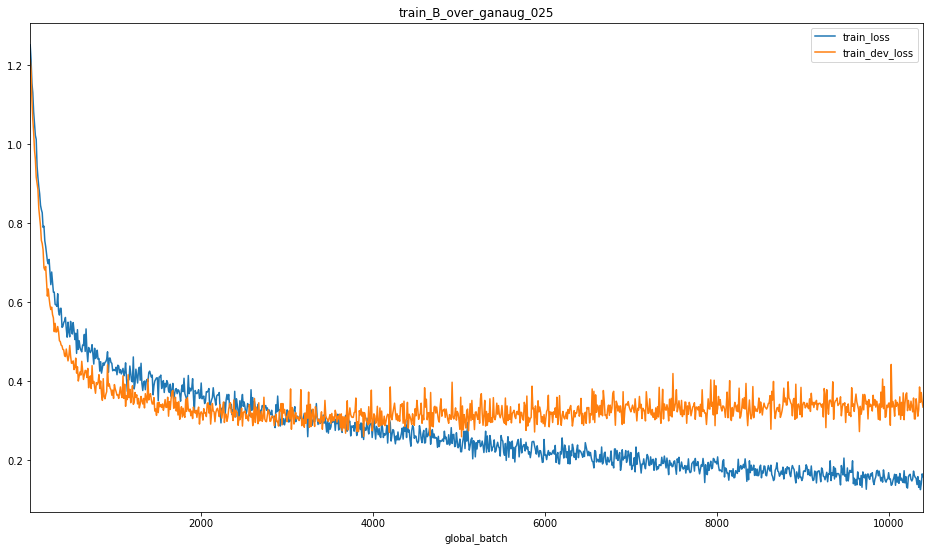

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.8405,0.7750
2,0.5525,0.4860
3,0.4800,0.4150
4,0.4435,0.3785
5,0.4195,0.3610


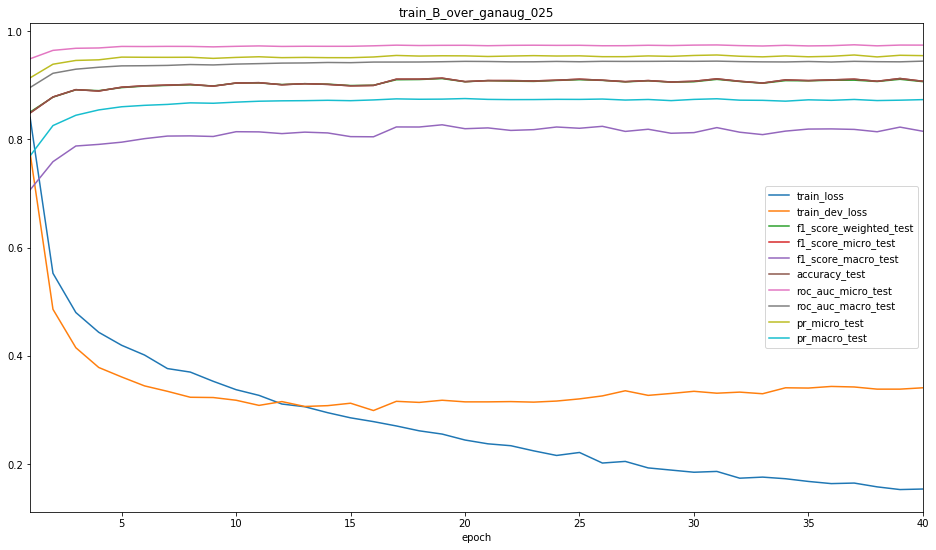

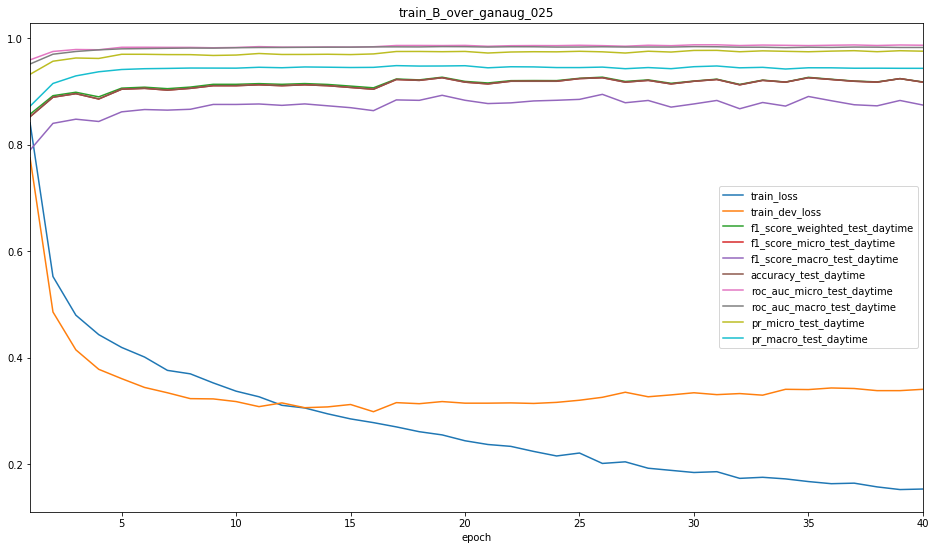

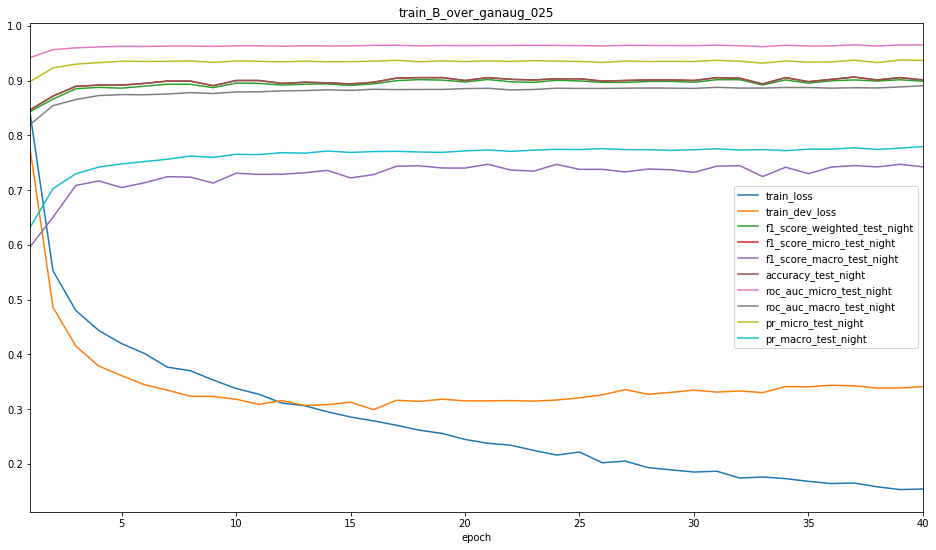

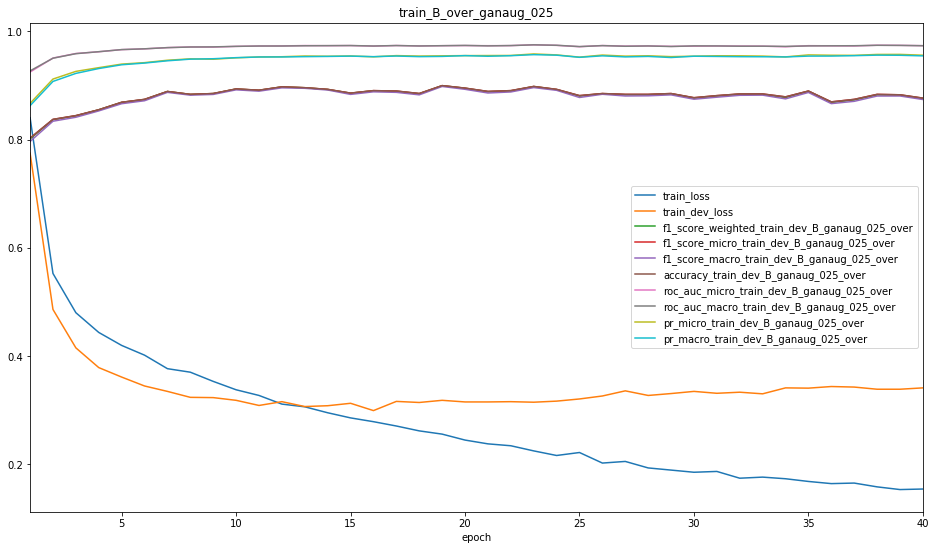

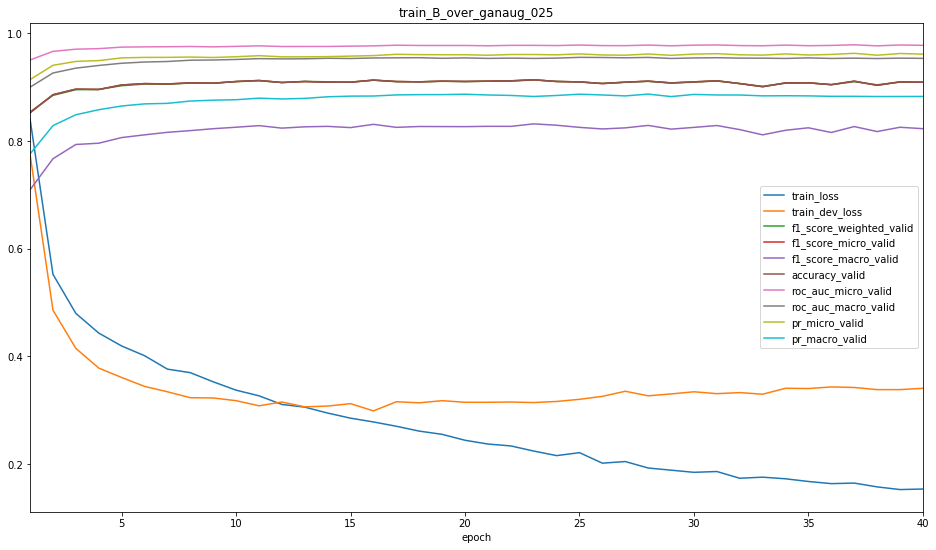

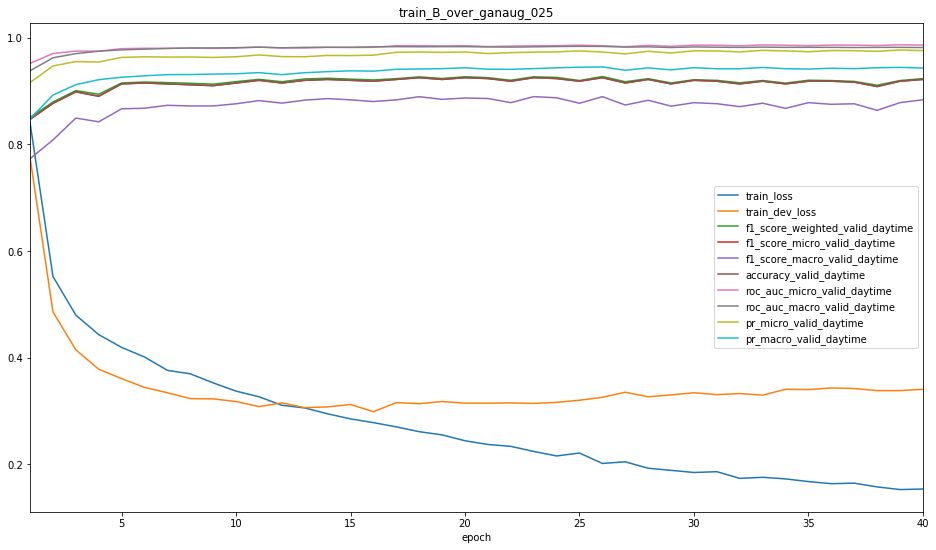

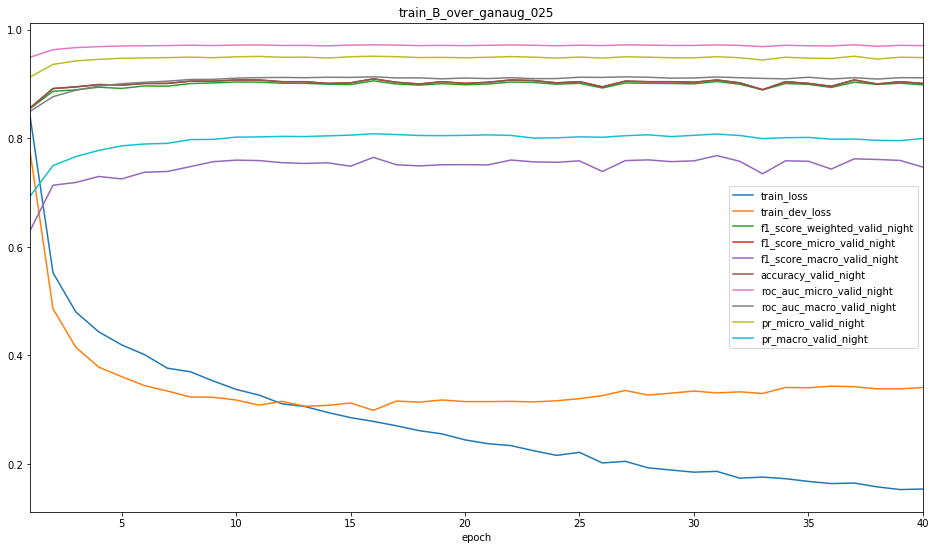

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)